# Pythonチャレンジ: 地震データを探る

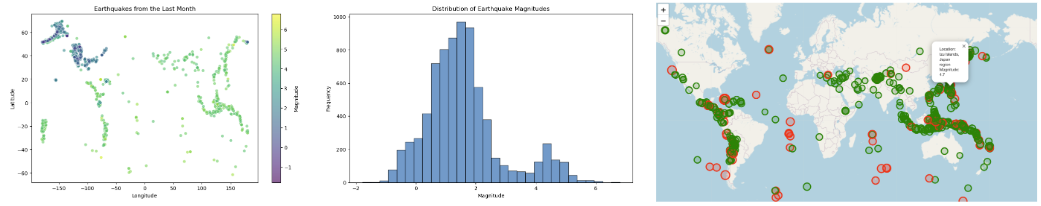

目的: Pythonを使ってUSGS（アメリカ地質調査所）のリアルタイム地震APIから最新の地震データを取得し、意味のある分析を行います。このチャレンジの最終目標は、世界中の地震を視覚化することです。

## 始めに

参考リンク：

- USGS 地震プログラム ホームページ: https://www.usgs.gov/programs/earthquake-hazards/earthquakes
- リアルタイムCSVデータ（スプレッドシート）API: https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php

データの取得: USGSのリアルタイム地震APIを使用して、最新の地震データを取得します。APIの基本URLは以下の通りです：

https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

以下のPythonスクリプトを作成して：
- APIにリクエストを送信。
- csv形式のレスポンスを解析し、各地震の位置、マグニチュード、深さ、発生時刻などの情報を抽出します。

### リクエストコード例

In [1]:
%pip install pandas requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import requests

# USGSから過去1か月の地震データを取得
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
response = requests.get(url)

# データをファイルに保存
with open('earthquakes.csv', 'wb') as file:
    file.write(response.content)

# データをDataFrameに読み込む
data = pd.read_csv('earthquakes.csv')

# データの最初の5行を表示
data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-11-05T05:29:06.697Z,31.702000,-104.16700,4.1419,1.6,ml,31.0,60.0,0.10000,0.30,...,2025-11-05T05:34:00.165Z,"53 km W of Mentone, Texas",earthquake,0.00,0.960428,0.200,22.0,automatic,tx,tx
1,2025-11-05T05:28:48.472Z,62.966600,-150.81150,117.4000,1.8,ml,NaN,NaN,NaN,0.26,...,2025-11-05T05:30:52.287Z,"52 km N of Petersville, Alaska",earthquake,NaN,1.100000,NaN,NaN,automatic,ak,ak
2,2025-11-05T05:16:22.542Z,57.091400,-156.98690,33.4000,1.9,ml,NaN,NaN,NaN,1.05,...,2025-11-05T05:18:16.729Z,"53 km SSE of Ugashik, Alaska",earthquake,NaN,0.700000,NaN,NaN,automatic,ak,ak
3,2025-11-05T05:14:42.880Z,36.969002,-121.62133,4.5600,1.3,md,13.0,68.0,0.03431,0.07,...,2025-11-05T05:32:18.800Z,"6 km SW of Gilroy, CA",earthquake,0.28,0.690000,0.240,14.0,automatic,nc,nc
4,2025-11-05T04:38:29.871Z,44.560600,-112.20010,12.6560,2.7,ml,44.0,37.0,0.32200,0.74,...,2025-11-05T04:47:55.040Z,"22 km N of Spencer, Idaho",earthquake,1.50,6.618000,0.033,120.0,reviewed,us,us


## チャレンジ

**チャレンジ1: データの取得と表示**

APIから地震データを取得し、以下を表示：
- 過去1ヶ月に報告された地震の総数
- 最大マグニチュードの地震とその発生場所と日にち
- 日本での地震の数

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# === 1. USGSから過去1ヶ月の地震データを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,  # M1.0以上に限定
    "limit": 20000  # 最大件数
}

response = requests.get(url, params=params)
data = response.json()

# === 2. データをDataFrame化 ===
features = data["features"]
records = []
for f in features:
    props = f["properties"]
    coords = f["geometry"]["coordinates"]
    records.append({
        "time": datetime.utcfromtimestamp(props["time"] / 1000),
        "place": props["place"],
        "magnitude": props["mag"],
        "longitude": coords[0],
        "latitude": coords[1]
    })

df = pd.DataFrame(records)

# === 3. 総数を表示 ===
total_quakes = len(df)
print(f"🌍 過去1ヶ月の地震の総数: {total_quakes} 件")

# === 4. 最大マグニチュードの地震 ===
max_quake = df.loc[df["magnitude"].idxmax()]
print(f"💥 最大マグニチュード: {max_quake['magnitude']}")
print(f"📍 発生場所: {max_quake['place']}")
print(f"🕒 発生日時(UTC): {max_quake['time']}")

# === 5. 日本付近の地震のみ抽出 ===
# 日本付近の緯度経度範囲でフィルタ（おおよそ）
japan_df = df[
    (df["latitude"].between(24, 46)) &
    (df["longitude"].between(122, 154))
].copy()

# 日ごとの地震数をカウント
japan_df["date"] = japan_df["time"].dt.date
daily_counts = japan_df.groupby("date").size()

print("\n📅 日本付近の地震発生数（日ごと）:")
print(daily_counts)

# === 6. 結果をCSVに保存したい場合 ===
# japan_df.to_csv("japan_earthquakes_last_month.csv", index=False)

C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\2707493545.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🌍 過去1ヶ月の地震の総数: 5356 件
💥 最大マグニチュード: 7.6
📍 発生場所: Drake Passage
🕒 発生日時(UTC): 2025-10-10 20:29:20.591000

📅 日本付近の地震発生数（日ごと）:
date
2025-10-06    8
2025-10-07    8
2025-10-08    2
2025-10-09    2
2025-10-10    1
2025-10-11    2
2025-10-12    2
2025-10-13    2
2025-10-14    3
2025-10-15    1
2025-10-17    1
2025-10-18    3
2025-10-19    1
2025-10-20    1
2025-10-21    1
2025-10-22    1
2025-10-23    1
2025-10-24    5
2025-10-25    1
2025-10-26    2
2025-10-30    1
2025-11-01    1
2025-11-02    2
2025-11-03    2
2025-11-04    3
dtype: int64


C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\2707493545.py:28: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "time": datetime.utcfromtimestamp(props["time"] / 1000),


**チャレンジ2: 重要な地震のフィルタリング**

- マグニチュードが6.0を超える地震をフィルタリングし、`for` ループを使って以下をリストアップ：
    - その位置、マグニチュード、発生時刻
    - このような重要な地震の総数


In [4]:
import requests
from datetime import datetime, timedelta

# === 1. 過去1ヶ月の地震データをUSGSから取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,  # M1以上
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. featuresから地震データを抽出 ===
features = data["features"]

# === 3. 重要な地震（M6.0超）をフィルタリング ===
important_quakes = []
for f in features:
    props = f["properties"]
    mag = props["mag"]
    place = props["place"]
    time = datetime.utcfromtimestamp(props["time"] / 1000)
    if mag and mag > 6.0:
        important_quakes.append({
            "place": place,
            "magnitude": mag,
            "time": time
        })

# === 4. 結果を表示 ===
print("🌋 マグニチュード6.0を超える地震（過去1ヶ月）:")
print("-" * 60)

for quake in important_quakes:
    print(f"📍 位置: {quake['place']}")
    print(f"💥 マグニチュード: {quake['magnitude']}")
    print(f"🕒 発生時刻(UTC): {quake['time']}")
    print("-" * 60)

print(f"🔢 重要な地震の総数: {len(important_quakes)} 件")


C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\2299699479.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🌋 マグニチュード6.0を超える地震（過去1ヶ月）:
------------------------------------------------------------
📍 位置: 155 km SE of Petropavlovsk-Kamchatsky, Russia
💥 マグニチュード: 6.1
🕒 発生時刻(UTC): 2025-11-03 08:44:43.471000
------------------------------------------------------------
📍 位置: 22 km WSW of Khulm, Afghanistan
💥 マグニチュード: 6.3
🕒 発生時刻(UTC): 2025-11-02 20:29:02.028000
------------------------------------------------------------
📍 位置: Banda Sea
💥 マグニチュード: 6.4
🕒 発生時刻(UTC): 2025-10-28 14:40:18.476000
------------------------------------------------------------
📍 位置: 162 km E of Beauséjour, Guadeloupe
💥 マグニチュード: 6.5
🕒 発生時刻(UTC): 2025-10-27 12:38:40.311000
------------------------------------------------------------
📍 位置: 59 km NW of Pante Makasar, Timor Leste
💥 マグニチュード: 6.2
🕒 発生時刻(UTC): 2025-10-26 17:04:25.645000
------------------------------------------------------------
📍 位置: 0 km WSW of Union, Philippines
💥 マグニチュード: 6.1
🕒 発生時刻(UTC): 2025-10-16 23:03:16.195000
------------------------------------------------

C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\2299699479.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time = datetime.utcfromtimestamp(props["time"] / 1000)


**チャレンジ3: 地震の深さを分析**

- すべての地震の平均深度を計算してください。
- 地震を以下のカテゴリに分類し、それぞれの数を数えてください：
    - 浅い地震 (<70 km)
    - 中間深度地震 (70–300 km)
    - 深い地震 (>300 km)


In [5]:
import requests
from datetime import datetime, timedelta

# === 1. USGS API から過去30日のデータを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. features から深さデータを抽出 ===
features = data["features"]

depths = []
for f in features:
    geom = f["geometry"]
    if geom and "coordinates" in geom:
        coords = geom["coordinates"]
        if len(coords) == 3:
            depth = coords[2]  # 深さは3番目の要素
            depths.append(depth)

# === 3. 平均深度の計算 ===
if len(depths) > 0:
    avg_depth = sum(depths) / len(depths)
else:
    avg_depth = 0

# === 4. 深さカテゴリごとにカウント ===
shallow = len([d for d in depths if d < 70])
intermediate = len([d for d in depths if 70 <= d <= 300])
deep = len([d for d in depths if d > 300])

# === 5. 結果を出力 ===
print("🌍 過去1ヶ月の地震深度分析 (USGS)")
print("-" * 50)
print(f"📊 平均深度: {avg_depth:.2f} km")
print(f"🟢 浅い地震 (<70km): {shallow} 件")
print(f"🟡 中間深度地震 (70–300km): {intermediate} 件")
print(f"🔵 深い地震 (>300km): {deep} 件")
print(f"📈 総地震数: {len(depths)} 件")


C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\33301874.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🌍 過去1ヶ月の地震深度分析 (USGS)
--------------------------------------------------
📊 平均深度: 27.38 km
🟢 浅い地震 (<70km): 4786 件
🟡 中間深度地震 (70–300km): 511 件
🔵 深い地震 (>300km): 60 件
📈 総地震数: 5357 件


**チャレンジ4: 時間分析**

- 地震のタイムスタンプ（ミリ秒単位のUNIX時間）を人間が読みやすい形式に変換して、日本時間として表示
- データセット内の最も早い地震と最新の地震の発生時刻を見つけてください。

In [6]:
import requests
from datetime import datetime, timedelta, timezone

# === 1. USGS API から過去30日の地震データを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. JST（日本時間）用のタイムゾーンを定義 ===
JST = timezone(timedelta(hours=9))

# === 3. すべての地震の時刻をリスト化（UNIX ms → datetime JST） ===
times_jst = []
for f in data["features"]:
    t_ms = f["properties"]["time"]  # ミリ秒単位のUNIX時間
    t_jst = datetime.fromtimestamp(t_ms / 1000, tz=JST)
    times_jst.append(t_jst)

# === 4. 最も早い（古い）地震と最新の地震を特定 ===
if times_jst:
    earliest = min(times_jst)
    latest = max(times_jst)
else:
    earliest = latest = None

# === 5. 結果を表示 ===
print("🕒 USGS 地震データ 時間分析（過去1ヶ月）")
print("-" * 60)
print(f"📅 総地震数: {len(times_jst)} 件")
if earliest and latest:
    print(f"⏰ 最も早い地震（最古）: {earliest.strftime('%Y-%m-%d %H:%M:%S %Z')}")
    print(f"🕘 最新の地震: {latest.strftime('%Y-%m-%d %H:%M:%S %Z')}")
else:
    print("⚠️ データが取得できませんでした。")


C:\Users\shunk\AppData\Local\Temp\ipykernel_18288\206779130.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🕒 USGS 地震データ 時間分析（過去1ヶ月）
------------------------------------------------------------
📅 総地震数: 5357 件
⏰ 最も早い地震（最古）: 2025-10-06 09:16:10 UTC+09:00
🕘 最新の地震: 2025-11-05 08:59:37 UTC+09:00


**チャレンジ5: 地震のマグニチュードを視覚化**

- 以下をプロットする棒グラフまたは散布図を作成してください：
    - x軸に地震のマグニチュード。
    - y軸に深さ。
    - 最大の地震と最も深い地震にラベルを追加。

In [15]:
pip install requests matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.0 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 10.5 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.5 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 10.6 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------- -------------------------- 2.4/7.0 MB 11.4 MB/s eta 0:00:01
   ---------------------------- ----------- 5.0/7.0 MB 11.6 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 10.3 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [p


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


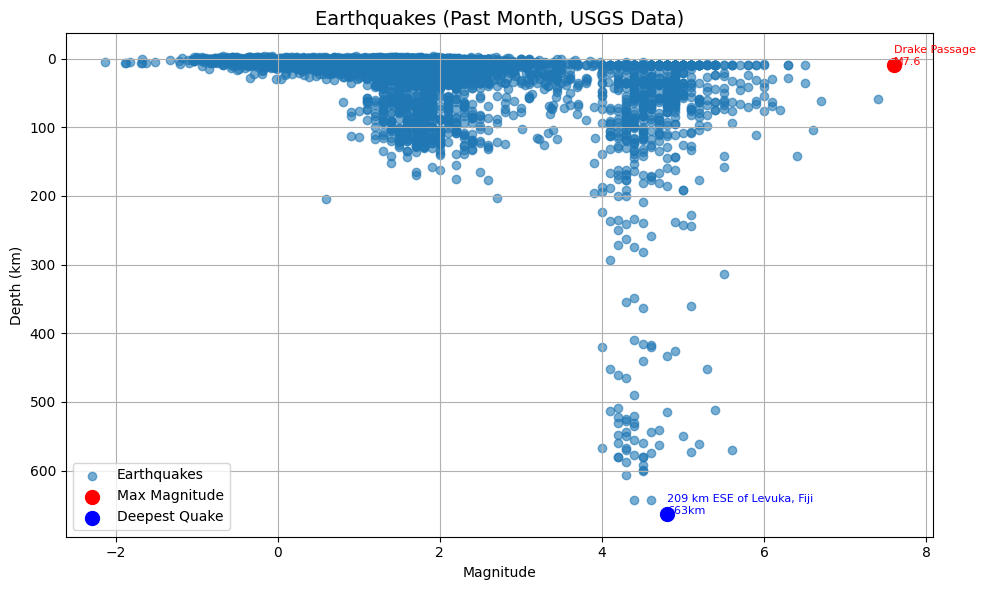

In [16]:
import requests
import matplotlib.pyplot as plt

# === USGS から過去1ヶ月の地震データを取得 ===
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
response = requests.get(url)
response.raise_for_status()
data = response.json()

features = data["features"]

# === データ抽出 ===
magnitudes = []
depths = []
locations = []

for quake in features:
    props = quake["properties"]
    geom = quake["geometry"]

    if props["mag"] is not None and geom and geom["coordinates"]:
        mag = props["mag"]
        depth = geom["coordinates"][2]  # 深さ（km）
        loc = props["place"] or "Unknown location"

        magnitudes.append(mag)
        depths.append(depth)
        locations.append(loc)

# === 最大マグニチュードと最大深度を特定 ===
max_mag = max(magnitudes)
max_depth = max(depths)

max_mag_index = magnitudes.index(max_mag)
max_depth_index = depths.index(max_depth)

max_mag_loc = locations[max_mag_index]
max_depth_loc = locations[max_depth_index]

# === 散布図を作成 ===
plt.figure(figsize=(10, 6))
plt.scatter(magnitudes, depths, alpha=0.6, label="Earthquakes")

# 最大マグニチュードの地震を赤で表示
plt.scatter(max_mag, depths[max_mag_index], color="red", s=100, label="Max Magnitude")
plt.text(max_mag, depths[max_mag_index], f"{max_mag_loc}\nM{max_mag:.1f}", fontsize=8, color="red")

# 最も深い地震を青で表示
plt.scatter(magnitudes[max_depth_index], max_depth, color="blue", s=100, label="Deepest Quake")
plt.text(magnitudes[max_depth_index], max_depth, f"{max_depth_loc}\n{max_depth:.0f}km", fontsize=8, color="blue")

# === 軸とタイトル ===
plt.title("Earthquakes (Past Month, USGS Data)", fontsize=14)
plt.xlabel("Magnitude")
plt.ylabel("Depth (km)")
plt.gca().invert_yaxis()  # 深い地震ほど下に
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**チャレンジ6（上級）: 地震のグローバルマップ作成**

- foliumまたはmatplotlibなどのマッピングライブラリを使用して、すべての地震を地図上にプロットしてください。
- 以下の特徴を追加してください：
    - 地震の位置をポイントで表示。
    - マグニチュードに基づいてポイントを色分け（例：<4.0は緑、4.0–6.0は黄色、>6.0は赤）。
    - ポイントにマウスを重ねると、地震の位置、マグニチュード、日本日付、深さを表示するツールチップを追加。

In [2]:
pip install requests folium



   ---------------------------------------- 0/5 [xyzservices]
   ---------------- ----------------------- 2/5 [jinja2]
   ---------------- ----------------------- 2/5 [jinja2]
   ---------------- ----------------------- 2/5 [jinja2]
   ---------------- ----------------------- 2/5 [jinja2]
   ---------------- ----------------------- 2/5 [jinja2]
   ---------------- ----------------------- 2/5 [jinja2]
   ------------------------ --------------- 3/5 [branca]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   -------------------------------- ------- 4/5 [folium]
   ---------------------------------------- 5/5 [folium]

Note: you may need to re


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import requests
import folium
from folium.plugins import MarkerCluster
from datetime import datetime, timedelta, timezone

def main():
    print("🌏 USGS地震データを取得中...")
    url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"

    try:
        res = requests.get(url, timeout=20)
        res.raise_for_status()
        data = res.json()
        features = data.get("features", [])
    except Exception as e:
        print("❌ データ取得エラー:", e)
        return

    if not features:
        print("⚠️ 地震データが見つかりません。")
        return

    # JST（日本時間）
    JST = timezone(timedelta(hours=9))

    # folium地図初期化
    m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")
    cluster = MarkerCluster().add_to(m)

    def get_color(mag):
        """マグニチュードによる色分け"""
        if mag is None:
            return "gray"
        elif mag < 4.0:
            return "green"
        elif mag < 6.0:
            return "orange"
        else:
            return "red"

    def get_radius(mag):
        """マグニチュードに基づくマーカーサイズ"""
        if mag is None:
            return 3
        return max(3, min(15, mag * 2))

    count = 0
    for f in features:
        try:
            props = f.get("properties", {})
            geom = f.get("geometry", {})
            coords = geom.get("coordinates", [])

            if len(coords) < 3:
                continue

            lon, lat, depth = coords
            mag = props.get("mag")
            place = props.get("place", "Unknown location")

            # UNIXタイムをJSTに変換
            t = props.get("time")
            if t:
                jst_time = datetime.fromtimestamp(t / 1000, JST).strftime("%Y-%m-%d %H:%M:%S")
            else:
                jst_time = "不明"

            color = get_color(mag)
            radius = get_radius(mag)

            tooltip_html = (
                f"<b>場所:</b> {place}<br>"
                f"<b>マグニチュード:</b> {mag if mag else '不明'}<br>"
                f"<b>日本時間:</b> {jst_time}<br>"
                f"<b>深さ:</b> {depth:.1f} km"
            )

            folium.CircleMarker(
                location=[lat, lon],
                radius=radius,
                color=None,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                tooltip=tooltip_html,
            ).add_to(cluster)
            count += 1
        except Exception:
            continue

    output_file = "usgs_earthquakes_map.html"
    m.save(output_file)

    print(f"✅ 地震データを地図にプロットしました（{count}件）")
    print(f"📄 ファイルを開く: {output_file}")

if __name__ == "__main__":
    main()


🌏 USGS地震データを取得中...
✅ 地震データを地図にプロットしました（7641件）
📄 ファイルを開く: usgs_earthquakes_map.html


# 課題提出

### Theme: Impact Visualization Challenge
USGSのライブ地震データを使って、**Impact** を感じる可視化や分析を作ってください。  
自分で考えて、探して、形にしてください。説明や手順はありません。

---

### How to Begin
1. **VS Code** を開く  
2. 自分の **GitHub「me」リポジトリ** の中に **新しいフォルダ** を作成 → 名前は **Week6**  
3. その中に **earthquake.ipynb** というファイルを作る  
4. **Markdown cell** を追加して、タイトルと自分の作品の説明を書く  
5. **Code cell** を追加し、ライブラリと **USGS データ** をインポートする（授業で使ったコードをコピー）  
6. さらに自分の **code cells** を追加して、可視化や分析を完成させる  

---

### 提出内容
- **Jupyter Notebook (.ipynb)**（code cells と markdown cells を含む）  
- **図または地図**（image または HTML）  
- **日本語サマリー（200〜400字）**：やったこと・わかったこと・感じたこと  

---

### 提出方法
成果物を **GitHub** にコミットし、`.ipynb` への **direct link** を **UNIPA** に提出。  
ファイルのアップロードは禁止。

---

### 評価
- **9–10：素晴らしい**  
- **7–8：ま〜ま〜**  
- **6：ギリOK**  
- **0：未提出**